In [47]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.api import adfuller
import datetime

In [48]:
def stationary(x,regr : {"c","ct","ctt","n"}):
    pval=round(adfuller(x,regression=regr)[1],4)
    if pval<=0.05 :
        print('Stationary series:','P value ADF: ', pval,end='')
    else:
        print('Non-stationary series:','P value ADF:', pval,end='')

## Sentiment indexes
Indexes, reflecting different uncertanties, impacting investor interest towards crypto

#### WUI (World Uncertainty Index)

In [49]:
WUI=pd.read_excel('wui_monthly.xlsx',sheet_name='F1',skiprows=2,index_col=0)

In [50]:
WUI=WUI.loc[(WUI.index>='2017-07-01')&(WUI.index<='2023-01-31') ]

In [51]:
WUI.rename(columns={'WUI, GDP weighted average':'WUI'},inplace=True)

In [52]:
stationary(WUI,regr='c')

Non-stationary series: P value ADF: 0.0555

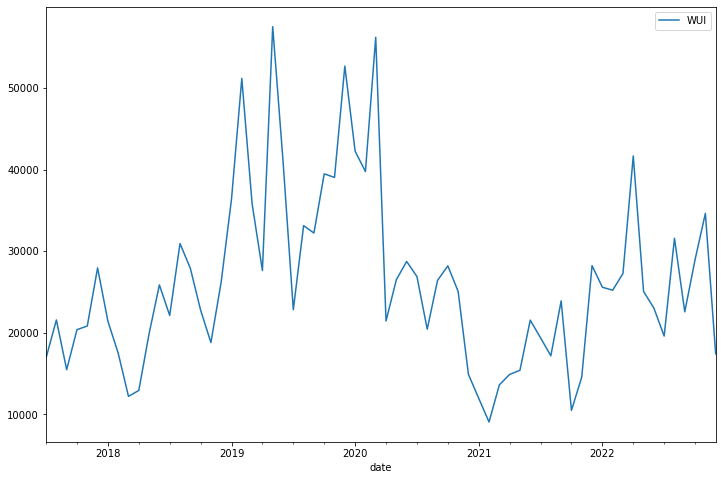

In [53]:
WUI.plot(figsize=(12,8));

#### Geopolitical Risk

In [54]:
GPR=pd.read_excel('data_gpr_export.xls',usecols=range(2),index_col=0).dropna()

In [55]:
GPR=GPR.loc[(GPR.index>='2017-07-01')&(GPR.index<='2023-01-31') ]

In [56]:
stationary(GPR,regr='c')

Stationary series: P value ADF:  0.0177

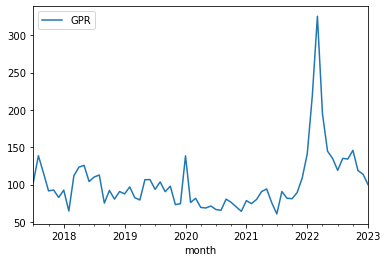

In [57]:
GPR.plot();

#### The Cryptocurrency Policy/Price Uncertainty Index

In [58]:
UCRY=pd.read_csv('UCRY Weekly Data Updating_Available until 2022 Q4.csv')

UCRY['date']=pd.to_datetime(UCRY.Timeline.str.split('-', expand=True)[1], dayfirst=True)

UCRY=UCRY.set_index('date').drop(columns=['Timeline','Date'])

In [59]:
UCRY=UCRY.loc[(UCRY.index>='2017-07-01')&(UCRY.index<='2023-01-31') ]

In [60]:
print('UCRY Policy Index:')
stationary(UCRY['UCRY Policy Index'],regr='c')
print('\nUCRY Price Index')
stationary(UCRY['UCRY Price Index'],regr='c')

UCRY Policy Index:
Non-stationary series: P value ADF: 0.7929
UCRY Price Index
Non-stationary series: P value ADF: 0.8162

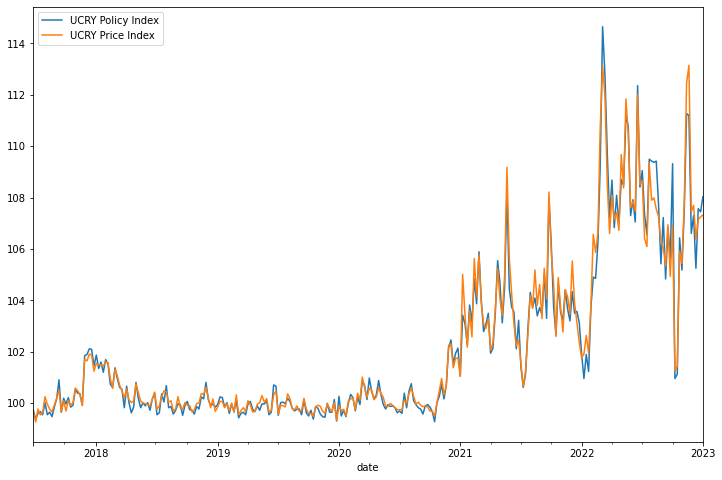

In [61]:
UCRY.plot(figsize=(12,8));

## Crypto dataset

First trading day on Binance for tokens:  
BTCUSDT :	 2017-08-17  
ETHUSDT :	 2017-08-17  
BNBUSDT :	 2017-11-06  
XRPUSDT :	 2018-05-04  
ADAUSDT :	 2018-04-17  
DOGEUSDT :	 2019-07-05  
MATICUSDT :	 2019-04-26  
LTCUSDT :	 2017-12-13  

Since some tokens have later first trading day (e.g. DOGE and MATIC), dataframe is shortened by a large part. We are interested also in a long term relation of the cryptocurrencies.  
To solve this problem, we implement two VARs on different datasets: longer one, consisting of BTC, ETH, BNB, LTC. And a shorter one with all available crypto currencies. Corresponding first dates are 2017-12-13 and 2019-07-05.

In [93]:
a=pd.read_csv('all_coins.csv',index_col=0).dropna().drop(index='2020-03-12')
b=pd.read_csv('all_coins.csv',index_col=0)[['BTCUSDT','ETHUSDT','BNBUSDT','LTCUSDT']].dropna()\
    .drop(index='2020-03-12')

####  Preprocessing
Next stage is implementation of a DCC model in R.

In [63]:
((a.applymap(float)/a.shift(1).applymap(float)).apply(np.log)*100).dropna().to_csv('all_coins_short.csv')
((b.applymap(float)/b.shift(1).applymap(float)).apply(np.log)*100).dropna().to_csv('all_coins_long.csv')

## Mergind sentiment data with crypto series

### Weekly frequency

Short period dataset

In [64]:
all_coins=pd.read_csv('all_coins.csv',index_col=0).dropna()
all_coins=all_coins.loc[all_coins.index>='2019-07-07'].iloc[::7,:]

weekly_Rt=pd.DataFrame()
for column in all_coins:    
    weekly_Rt[column]=(all_coins[column]/all_coins[column].shift(1)).apply(np.log)*100
weekly_Rt.dropna(inplace=True)

weekly_Rt.index=weekly_Rt.index.astype('datetime64[ns]')

UCRY_short=UCRY.loc[UCRY.index>'2019-07-06']

df_short=weekly_Rt.merge(UCRY_short,left_index=True,right_index=True)
#df_short.to_csv('weekly_short.csv')

In [65]:
all_coins=pd.read_csv('all_coins.csv',index_col=0)[['BTCUSDT','ETHUSDT','BNBUSDT','LTCUSDT']].dropna()
all_coins=all_coins.loc[all_coins.index>='2017-12-17'].iloc[::7,:]

weekly_Rt=pd.DataFrame()
for column in all_coins:    
    weekly_Rt[column]=(all_coins[column]/all_coins[column].shift(1)).apply(np.log)*100
weekly_Rt.dropna(inplace=True)

weekly_Rt.index=weekly_Rt.index.astype('datetime64[ns]')

UCRY_short=UCRY.loc[UCRY.index>='2017-12-17']

df_long=weekly_Rt.merge(UCRY_short,left_index=True,right_index=True)
#df_long.to_csv('weekly_long.csv')

#### Achieving stationarity

In [94]:
for column in df_short:
    print('\n',column,end='\t')
    stationary(x=df_short[column],regr='c')


 BTCUSDT	Stationary series: P value ADF:  0.0
 ETHUSDT	Stationary series: P value ADF:  0.0
 BNBUSDT	Stationary series: P value ADF:  0.0
 XRPUSDT	Stationary series: P value ADF:  0.0
 ADAUSDT	Non-stationary series: P value ADF: 0.8226
 DOGEUSDT	Stationary series: P value ADF:  0.0
 MATICUSDT	Stationary series: P value ADF:  0.0
 LTCUSDT	Stationary series: P value ADF:  0.0
 WUI	Stationary series: P value ADF:  0.028
 GPR	Non-stationary series: P value ADF: 0.154

In [95]:
df_short_diff=df_short.diff().dropna()

In [96]:
for column in df_short_diff:
    print('\n',column,end='\t')
    stationary(x=df_short_diff[column],regr='c')


 BTCUSDT	Stationary series: P value ADF:  0.0
 ETHUSDT	Non-stationary series: P value ADF: 0.4736
 BNBUSDT	Stationary series: P value ADF:  0.0001
 XRPUSDT	Stationary series: P value ADF:  0.0
 ADAUSDT	Stationary series: P value ADF:  0.0
 DOGEUSDT	Stationary series: P value ADF:  0.0
 MATICUSDT	Stationary series: P value ADF:  0.0002
 LTCUSDT	Stationary series: P value ADF:  0.0
 WUI	Stationary series: P value ADF:  0.0
 GPR	Stationary series: P value ADF:  0.0

Long period dataset

In [97]:
for column in df_long:
    print('\n',column,end='\t')
    stationary(x=df_short[column],regr='c')


 BTCUSDT	Stationary series: P value ADF:  0.0
 ETHUSDT	Stationary series: P value ADF:  0.0
 BNBUSDT	Stationary series: P value ADF:  0.0
 LTCUSDT	Stationary series: P value ADF:  0.0
 WUI	Stationary series: P value ADF:  0.028
 GPR	Non-stationary series: P value ADF: 0.154

In [98]:
df_long_diff=df_long.diff().dropna()

In [99]:
for column in df_long_diff:
    print('\n',column,end='\t')
    stationary(x=df_long_diff[column],regr='c')


 BTCUSDT	Stationary series: P value ADF:  0.0
 ETHUSDT	Stationary series: P value ADF:  0.0
 BNBUSDT	Stationary series: P value ADF:  0.0
 LTCUSDT	Stationary series: P value ADF:  0.0
 WUI	Stationary series: P value ADF:  0.0
 GPR	Stationary series: P value ADF:  0.0

#### VAR

In [100]:
from statsmodels.tsa.vector_ar.var_model import VAR

In [101]:
model=VAR(df_short_diff)
fit=model.fit(ic='bic',trend='c')
fit.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 21, Nov, 2023
Time:                     19:06:42
--------------------------------------------------------------------
No. of Equations:         10.0000    BIC:                    81.5986
Nobs:                     40.0000    HQIC:                   81.3291
Log likelihood:          -2181.10    FPE:                1.79685e+35
AIC:                      81.1764    Det(Omega_mle):     1.40370e+35
--------------------------------------------------------------------
Results for equation BTCUSDT
           coefficient       std. error           t-stat            prob
------------------------------------------------------------------------
const         0.033206         4.242866            0.008           0.994

Results for equation ETHUSDT
           coefficient       std. error           t-stat            prob
------------------------------------------------------------

In [102]:
model=VAR(df_long_diff)
fit=model.fit(ic='bic',trend='c')
fit.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 21, Nov, 2023
Time:                     19:06:43
--------------------------------------------------------------------
No. of Equations:         6.00000    BIC:                    52.1229
Nobs:                     59.0000    HQIC:                   51.9941
Log likelihood:          -2027.70    FPE:                3.50709e+22
AIC:                      51.9116    Det(Omega_mle):     3.17068e+22
--------------------------------------------------------------------
Results for equation BTCUSDT
           coefficient       std. error           t-stat            prob
------------------------------------------------------------------------
const         0.425469         3.653329            0.116           0.907

Results for equation ETHUSDT
           coefficient       std. error           t-stat            prob
------------------------------------------------------------

### Monthly frequency

#### Short period dataset

In [103]:
all_coins=pd.read_csv('all_coins.csv',index_col=0).dropna()

all_coins.index=all_coins.index.astype('datetime64[ns]')

all_coins=all_coins.groupby(pd.Grouper(freq='M')).last()

In [104]:
WUI.index=WUI.index.to_period('M').to_timestamp('M')
GPR.index=GPR.index.to_period('M').to_timestamp('M')

In [105]:
monthly_Rt=pd.DataFrame()
for column in all_coins:    
    monthly_Rt[column]=(all_coins[column]/all_coins[column].shift(1)).apply(np.log)*100
monthly_Rt.dropna(inplace=True)
monthly_Rt.index=monthly_Rt.index.astype('datetime64[ns]')

In [106]:
df_short=monthly_Rt.merge(WUI,left_index=True,right_index=True)\
                    .merge(GPR,left_index=True,right_index=True)

In [107]:
for column in df_short:
    print('\n',column,end='\t')
    stationary(df_short[column],regr='c')


 BTCUSDT	Stationary series: P value ADF:  0.0
 ETHUSDT	Stationary series: P value ADF:  0.0
 BNBUSDT	Stationary series: P value ADF:  0.0
 XRPUSDT	Stationary series: P value ADF:  0.0
 ADAUSDT	Non-stationary series: P value ADF: 0.8226
 DOGEUSDT	Stationary series: P value ADF:  0.0
 MATICUSDT	Stationary series: P value ADF:  0.0
 LTCUSDT	Stationary series: P value ADF:  0.0
 WUI	Stationary series: P value ADF:  0.028
 GPR	Non-stationary series: P value ADF: 0.154

In [108]:
df_short_diff=df_short.diff().dropna()
for column in df_short_diff:
    print('\n',column,end='\t')
    stationary(df_short_diff[column],regr='c')


 BTCUSDT	Stationary series: P value ADF:  0.0
 ETHUSDT	Non-stationary series: P value ADF: 0.4736
 BNBUSDT	Stationary series: P value ADF:  0.0001
 XRPUSDT	Stationary series: P value ADF:  0.0
 ADAUSDT	Stationary series: P value ADF:  0.0
 DOGEUSDT	Stationary series: P value ADF:  0.0
 MATICUSDT	Stationary series: P value ADF:  0.0002
 LTCUSDT	Stationary series: P value ADF:  0.0
 WUI	Stationary series: P value ADF:  0.0
 GPR	Stationary series: P value ADF:  0.0

In [109]:
#second difference
df_short_diff2=df_short_diff.diff().dropna()
for column in df_short_diff:
    print('\n',column,end='\t')
    stationary(df_short_diff.diff()[column].dropna(),regr='c')


 BTCUSDT	Stationary series: P value ADF:  0.0003
 ETHUSDT	Stationary series: P value ADF:  0.0069
 BNBUSDT	Stationary series: P value ADF:  0.0001
 XRPUSDT	Stationary series: P value ADF:  0.0
 ADAUSDT	Stationary series: P value ADF:  0.0
 DOGEUSDT	Stationary series: P value ADF:  0.0
 MATICUSDT	Stationary series: P value ADF:  0.0009
 LTCUSDT	Stationary series: P value ADF:  0.037
 WUI	Stationary series: P value ADF:  0.0017
 GPR	Stationary series: P value ADF:  0.0001

## VAR results

In [110]:
model=VAR(df_short_diff2)
fit=model.fit(ic='bic',trend='c')
fit.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 21, Nov, 2023
Time:                     19:07:11
--------------------------------------------------------------------
No. of Equations:         10.0000    BIC:                    82.7664
Nobs:                     37.0000    HQIC:                   76.8467
Log likelihood:          -1677.04    FPE:                4.33979e+32
AIC:                      73.6234    Det(Omega_mle):     4.84402e+30
--------------------------------------------------------------------
Results for equation BTCUSDT
                  coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------
const               -0.445744         3.330810           -0.134           0.894
L1.BTCUSDT          -0.002411         0.371310           -0.006           0.995
L1.ETHUSDT          -0.644626         0.336686           -1.91

In [111]:
#df_short.to_csv('monthly_short.csv')

#### Long time period (2017-12-31 - 2023-03-31)

In [90]:
all_coins=pd.read_csv('all_coins.csv',index_col=0)[['BTCUSDT','ETHUSDT','BNBUSDT','LTCUSDT']].dropna()

all_coins.index=all_coins.index.astype('datetime64[ns]')

all_coins=all_coins.groupby(pd.Grouper(freq='M')).last()

monthly_Rt=pd.DataFrame()
for column in all_coins:    
    monthly_Rt[column]=(all_coins[column]/all_coins[column].shift(1)).apply(np.log)*100
monthly_Rt.dropna(inplace=True)
monthly_Rt.index=monthly_Rt.index.astype('datetime64[ns]')

In [85]:
df_long=monthly_Rt.merge(WUI,left_index=True,right_index=True)\
                    .merge(GPR,left_index=True,right_index=True)

In [86]:
for column in df_long:
    print('\n',column,end='\t')
    stationary(df_long[column],regr='c')


 BTCUSDT	Stationary series: P value ADF:  0.0
 ETHUSDT	Stationary series: P value ADF:  0.0
 BNBUSDT	Stationary series: P value ADF:  0.0
 LTCUSDT	Stationary series: P value ADF:  0.0
 WUI	Non-stationary series: P value ADF: 0.0759
 GPR	Stationary series: P value ADF:  0.0338

In [87]:
df_long_diff=df_long.diff().dropna()
for column in df_long_diff:
    print('\n',column,end='\t')
    stationary(df_long_diff[column],regr='c')


 BTCUSDT	Stationary series: P value ADF:  0.0
 ETHUSDT	Stationary series: P value ADF:  0.0
 BNBUSDT	Stationary series: P value ADF:  0.0
 LTCUSDT	Stationary series: P value ADF:  0.0
 WUI	Stationary series: P value ADF:  0.0
 GPR	Stationary series: P value ADF:  0.0

In [91]:
all_coins

,BTCUSDT,ETHUSDT,BNBUSDT,LTCUSDT
date,,,,
2017-12-31,13716.36,733.98,8.5300,223.69
2018-01-31,10285.10,1124.81,11.3131,165.19
2018-02-28,10326.76,853.50,10.4536,201.86
2018-03-31,6923.91,393.92,11.0510,116.05
2018-04-30,9246.01,670.78,14.3291,148.37
...,...,...,...,...
2022-11-30,17163.64,1294.46,300.6000,79.16
2022-12-31,16542.40,1196.13,246.3000,70.14
2023-01-31,23125.13,1585.33,312.0000,94.09


In [88]:
#df_long.to_csv('monthly_long.csv')

In [89]:
model=VAR(df_long_diff)
fit=model.fit(maxlags=2,trend='c')
fit.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 21, Nov, 2023
Time:                     18:53:57
--------------------------------------------------------------------
No. of Equations:         6.00000    BIC:                    53.2384
Nobs:                     57.0000    HQIC:                   51.5292
Log likelihood:          -1844.89    FPE:                8.47703e+21
AIC:                      50.4427    Det(Omega_mle):     2.47118e+21
--------------------------------------------------------------------
Results for equation BTCUSDT
                coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------
const              0.231046         2.968029            0.078           0.938
L1.BTCUSDT        -0.224254         0.248923           -0.901           0.368
L1.ETHUSDT        -0.442749         0.151568           -2.921         